In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from numpy import random
from itertools import combinations, permutations, product
from collections import defaultdict 

from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import pyLDAvis
import pyLDAvis.gensim as gensimvis


import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
%matplotlib inline

In [69]:
dictionary = Dictionary.load('models/lda/models/lda_sample_805.id2word')

In [70]:
lda = LdaModel.load('models/lda/models/lda_sample_805')

In [4]:
dictionary[67]

'vuonna'

In [5]:
dictionary.num_docs

98100

In [6]:
df = pd.read_json('data/dev/cluster_12_cats.json')

In [43]:
df['category'].unique()

array(['autot', 'musiikki', 'luonto', 'vaalit', 'taudit', 'työllisyys',
       'jääkiekko', 'kulttuuri', 'rikokset', 'koulut', 'tulipalot',
       'ruoat'], dtype=object)

In [71]:
sample = pd.read_json('data/prod/samples/sample_805.json')

In [8]:
stops_fi = set(stopwords.words('finnish'))
stops_fi2 = open("data/stopwords_fi_nlf.txt", "r").readlines()
stops_fi2 = [w.split()[1] for w in stops_fi2]
stops_fi.update(stops_fi2)

In [9]:
stops_fi = list(stops_fi)

In [10]:
def preprocessing(df, stopwords):
    # clean text and title and create new column "tokenized"
    tokens = df['title'].apply(simple_preprocess, max_len=30) + df['body'].apply(simple_preprocess, max_len=30)
    # remove stopwords
    tokens = [w for w in tokens if not w in stopwords]
    return tokens


In [11]:
%%time
df['tokens'] = preprocessing(df, stops_fi)

CPU times: user 1min 7s, sys: 1.13 s, total: 1min 8s
Wall time: 1min 8s


In [12]:
df.drop(['title', 'body', 'subjects', 'date'], axis=1, inplace=True)

In [11]:
df.head()

,id,category,tokens
0,3-6475275,autot,"[aika, kallis, volkkari, vuonna, autonvalmista..."
1,3-6475075,autot,"[kuopion, koruryöstäjille, kymmenien, tuhansie..."
2,3-6474561,autot,"[nuori, nainen, kuoli, kolarissa, virroilla, e..."
3,3-6474214,autot,"[autoasentajat, kurssikierteessä, kun, auton, ..."
4,3-6474222,autot,"[kertaa, kiinni, kortitta, ajosta, kokemäellä,..."


In [12]:
sample.head()

,id,category,time
0,3-8365251,autot,0
1,3-7331013,autot,0
2,3-6972053,autot,0
3,3-5394572,autot,0
4,3-10024700,autot,0


In [56]:
def get_sample_text(df_text, sample_ids):
    df = df_text.reset_index(drop=True)
    df = df.set_index('id')
    df_sample = df.loc[sample_ids]
    df_sample.reset_index(inplace=True)
    return df_sample

In [72]:
df_sample = get_sample_text(df, sample['id'])

In [73]:
df_sample.head()

,id,category,tokens
0,3-9671564,autot,"[rakkaus, syttyi, rundilla, vuotta, myöhemmin,..."
1,3-6533466,autot,"[talousongelmat, heijastuvat, hevosiin, espanj..."
2,3-8826519,autot,"[päästöskandaalin, kustannukset, volkswagenill..."
3,3-5389040,autot,"[kahden, seurakunnan, isä, viihtyy, lapissa, e..."
4,3-9489300,autot,"[hamiltonin, mersussa, ongelmia, williamsilla,..."


In [55]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125970 entries, 3-7552272 to 3-7067583
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  125970 non-null  object
 1   tokens    125970 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


In [74]:
sample['category'].unique()

array(['autot', 'musiikki', 'luonto', 'vaalit', 'taudit', 'työllisyys',
       'jääkiekko', 'kulttuuri', 'rikokset', 'koulut', 'tulipalot',
       'ruoat'], dtype=object)

In [75]:
corpus = [dictionary.doc2bow(doc) for doc in df_sample['tokens']]

In [54]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

In [86]:
# def get_docs_per_cluster(lda, corpus):
#     clusters = []
    
#     for doc in corpus:
#         topics = lda.get_document_topics(doc)
#         topics = [i[1] for i in topics]
#         top_id = np.argmax(topics)
#         clusters.append(top_id)
        
#     return clusters

def sort_tuple(tup):  
  
    # reverse = None (Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1], reverse=True)  
    return tup 

def get_docs_per_cluster(lda, corpus, min_prob=0.2):
    clusters = [list() for i in range(20)]
    
    for i, doc in enumerate(corpus):
        topics = lda.get_document_topics(doc)
        topics = sort_tuple(topics)
        temp = [i[0] for i in topics if i[1] >= min_prob]
        # if no topic qualify the min prob, get the first one
        if len(temp) == 0:
            clusters[topics[0][0]].append(i)
            
        # else get the max 2 topics for the doc
        for topic in temp[:2]:
            clusters[topic].append(i)
        
            
    return clusters

def get_clusters_per_doc(lda, corpus):
    clusters = []
    
    for i, doc in enumerate(corpus):
        topics = lda.get_document_topics(doc)
        topics = sort_tuple(topics)
        clusters.append(topics)
    
    return clusters
        

In [76]:
clusters = get_docs_per_cluster(lda, corpus, min_prob=0.2)

In [87]:
%%time
cluster_list = get_clusters_per_doc(lda, corpus)

CPU times: user 1min 35s, sys: 40.9 s, total: 2min 16s
Wall time: 57.3 s


In [89]:
cluster_list[1]

[(18, 0.37967378),
 (17, 0.1702898),
 (5, 0.062239513),
 (14, 0.061542764),
 (19, 0.059259947),
 (7, 0.043746855),
 (15, 0.04131148),
 (4, 0.03119153),
 (1, 0.029986253),
 (0, 0.026993612),
 (6, 0.025050698),
 (11, 0.019462125),
 (12, 0.017444875)]

In [77]:
topics = lda.get_document_topics(corpus[92], minimum_probability=0)
topics = sort_tuple(topics)


In [78]:
print(topics)

[(18, 0.2854443), (17, 0.16771924), (7, 0.1541696), (5, 0.09064318), (8, 0.06610534), (13, 0.060070224), (14, 0.03760239), (1, 0.031801328), (0, 0.018656693), (19, 0.013667286), (15, 0.011220308), (3, 0.010318149), (11, 0.009066542), (16, 0.008540235), (2, 0.007349662), (6, 0.0065135704), (9, 0.006208606), (4, 0.005425076), (12, 0.0047551347), (10, 0.0047230995)]


In [61]:
len(clusters[1])

9594

In [20]:
def get_topic_term(lda, dictionary):
    topics = []
    
    for i in range(20):
        terms = lda.get_topic_terms(i, topn=20)
        words = []
        for t in terms:
            words.append(dictionary[t[0]])
        topics.append(words)
        
    return topics

In [21]:
topic_terms = get_topic_term(lda, dictionary)

In [27]:
topic_terms = pd.DataFrame(topic_terms, columns=list(range(20)))

In [28]:
# topic_terms.to_csv('data/topic_terms.csv', index=False)

In [30]:
topic_terms

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,poliisi,mies,poliisin,miehen,käräjäoikeus,epäillään,kiinni,vuoden,vuotias,nainen,törkeästä,miehet,syyttäjä,helsingin,naisen,poliisille,käräjäoikeudessa,euroa,vuotiaan,epäilty
1,sanoo,kertoo,hetkellä,suomen,vuoden,voidaan,uuden,tarkoitus,tavoitteena,lapin,toteaa,myötä,lappeenrannan,vuotta,jatkossa,lahden,savon,avulla,ajan,käyttöön
2,porin,satakunnan,pirkanmaan,porissa,työttömien,työttömyys,uutiset,tuhoutunut,työttömiä,pirkanmaalla,satakunnassa,http,yksikköä,omakotitalo,pori,työpaikkoja,työttömyysaste,sammumaan,pahoin,kyselyyn
3,hallituksen,hallitus,presidentti,euroopan,tänään,pääministeri,kertoi,presidentin,yhdysvaltain,uutiset,tiistaina,keskiviikkona,maanantaina,britannian,aiemmin,saksan,torstaina,perjantaina,oikeus,http
4,prosenttia,puolueen,keskustan,vaaleissa,puheenjohtaja,vaalien,puolue,perussuomalaisten,kokoomuksen,ääntä,ylen,keskusta,ehdokas,äänistä,ehdokkaat,ääniä,perussuomalaiset,kansanedustaja,vaalit,ennakkoon
5,suomessa,ruokaa,ruoka,kiloa,kaupan,hinta,päivässä,ravintola,alan,suomeen,raaka,ruoan,tuotteita,ruuan,suomalaiset,ostaa,suomalaisten,myynti,puolet,maksaa
6,sanoo,kertoo,pitää,vain,hyvin,toteaa,ihmiset,hyvä,muistuttaa,kannattaa,saattaa,suomessa,tavalla,ihmisiä,voivat,voisi,vaikuttaa,tilanne,ihmisten,kyse
7,helsingin,suomen,vuonna,oulun,tampereen,turun,yliopiston,vuoden,järjestetään,helsingissä,jyväskylän,mukana,joensuun,perjantaina,kaupungin,tapahtuman,tänään,tapahtuma,opiskelijat,yliopisto
8,vuonna,vuoden,prosenttia,euroa,määrä,miljoonaa,vuotta,eniten,vuosi,hämeen,vähemmän,vuoteen,puolet,verrattuna,vain,vuosina,hieman,mennessä,maassa,euron
9,tutkimuksen,tutkimus,tutkijat,tulokset,tutkimuksessa,perusteella,http,riski,lehdessä,yliopiston,professori,lasten,suomessa,naisten,sydän,kiinan,julkaistiin,yhteys,tutkimukseen,voivat


In [57]:
topics = lda.get_document_topics(corpus[0])

In [59]:
topics = [i[1] for i in topics]

In [64]:
np.argmax(topics)

1

In [67]:
df_sample.head()

,date,category,tokens
id,,,
3-6886755,2013-11-01T09:44:45+0200,musiikki,"[ocsid, palaa, kotiin, yle, lahti, lc, lahti, ..."
3-8448518,2015-11-14T09:00:00+0200,musiikki,"[ei, enää, tien, päälle, lama, on, radiomainon..."
20-223453,2013-09-28T20:03:13+0300,musiikki,"[miley, cyrus, haluan, musiikkini, kestävän, a..."
20-266485,2016-10-01T11:03:33+0300,musiikki,"[cheek, avautui, mielenterveysongelmistaan, hs..."
3-9485917,2017-03-01T20:56:45+0200,musiikki,"[venäjältä, kiovaan, ukrainalainen, laulaja, d..."


In [62]:
def visualize_trending(df):
#     target = df[df['target'] == True]
#     noise = df[df['target'] == False]
#     t_group = target.groupby(['time'])['id'].count()
#     n_group = noise.groupby(['category'])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    for name, group in df.groupby(['category']):
        g = group.groupby(['time'])['id'].count()
        ax.plot(g.index, g.values, label=name)
    
    ax.set(xlabel='time', ylabel='Numbers')
    ax.legend()
    ax.grid()

    plt.show()
    
def get_target(df):
    target = df[df['event'] != 'noise']['category'].iloc[0]
    return target

# def get_cluster_change(clusters, sample):
#     sample['cluster'] = clusters
#     n_cluster = sample['cluster'].nunique()
#     changes = []
    
#     for g, cluster in sample.groupby('cluster'):
#         # count and sort by timeline
#         counts = cluster['time'].value_counts().sort_index()
#         # print(cluster['time'].nunique())
#         maj_class = cluster['category'].value_counts(normalize=True).index[0]
#         # diff = times.diff().fillna(0)
#         changes.append((g, maj_class, counts))
        
#     return changes


def get_cluster_change(clusters, sample):
    changes = []
    
    for i, ids in enumerate(clusters):
        # merge article index
        cluster = sample.iloc[ids]
        counts = cluster['time'].value_counts().sort_index()
        maj_class = cluster['category'].value_counts(normalize=True).index[0]
        # diff = times.diff().fillna(0)
        changes.append((i, maj_class, counts))
        
    return changes


def visualize_changes(changes, target):    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    distance = 0
    target_id = 0
    for cluster, maj_class, counts in changes:
        val = counts.values + distance
        if maj_class == target:
            target_id = cluster
            ax.plot(counts.index, val, label=maj_class, ls='--')
        else:
            ax.plot(counts.index, val, label=maj_class)
            
        distance += 20
    
    ax.set(xlabel='Time', ylabel='Counts')
    ax.legend()
    ax.grid()

    plt.show()
    print('cluster target:', target_id)
    return target_id

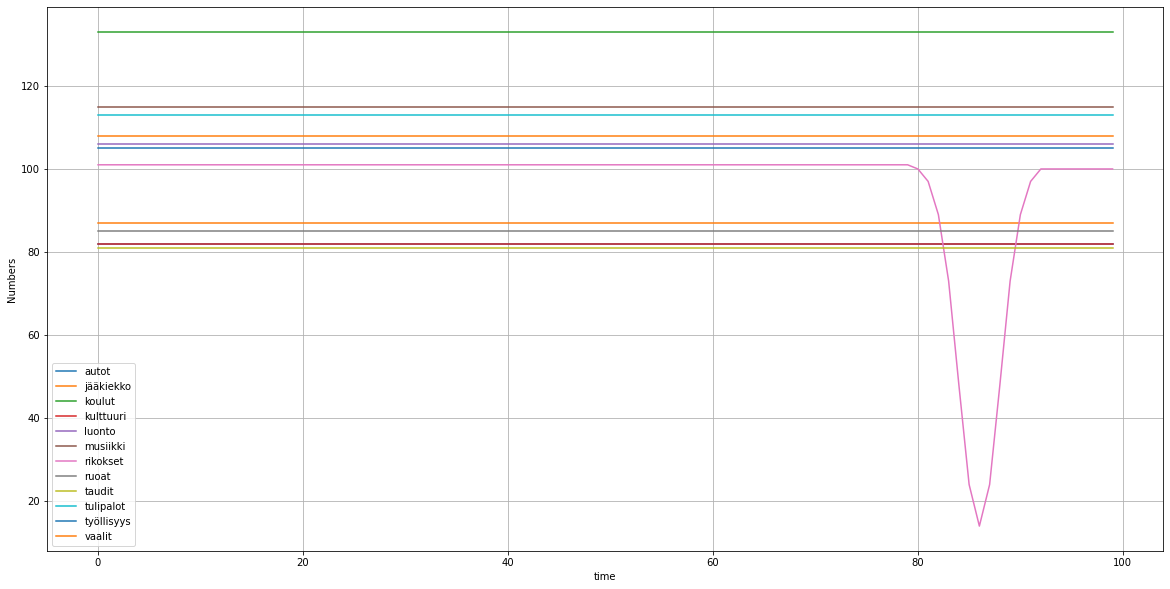

In [79]:
visualize_trending(sample)

In [80]:
target = "rikokset" #get_target(sample)

In [81]:
changes = get_cluster_change(clusters, sample)

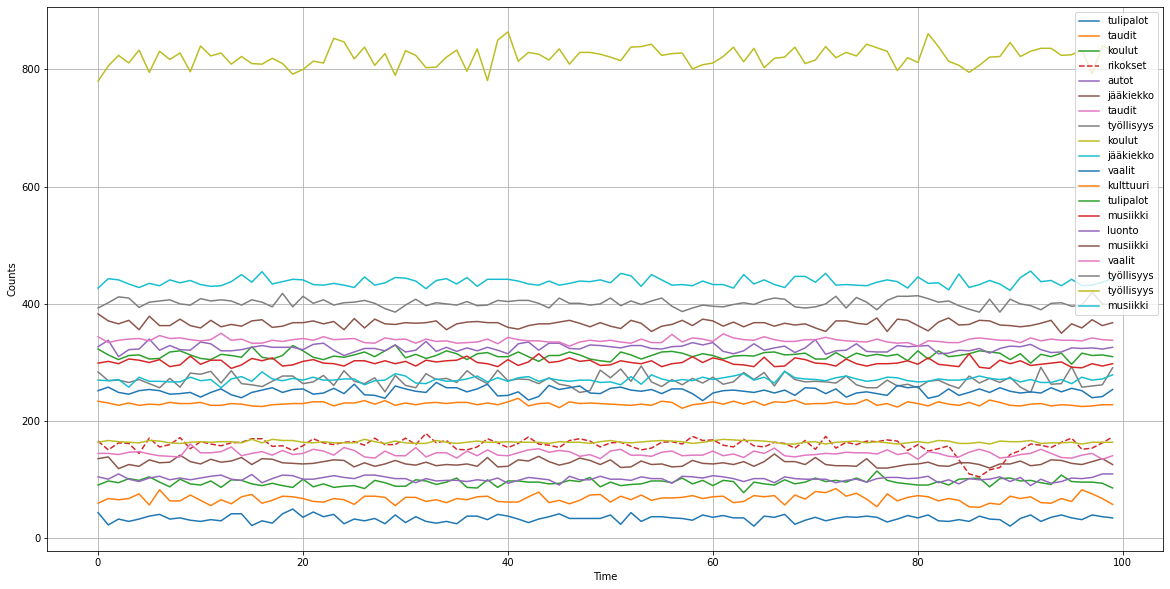

cluster target: 3


3

In [82]:
visualize_changes(changes, target)

In [2]:
def check_missing_lda():
    root = 'models/lda/lda_models'
    missing = []
    
    for i in range(2000):
        exist = os.path.isfile(os.path.join(root, 'lda_sample_' + str(i)))
        if not exist:
            missing.append(i)
    return missing

In [3]:
missing = check_missing_lda()

In [5]:
print(missing)

[139, 141, 1147, 1148, 1150, 1151, 1153, 1155, 1156, 1160, 1164, 1183, 1185, 1186, 1193, 1194, 1197, 1198, 1447, 1449, 1455, 1456, 1457, 1460, 1461]
